### Steps for Factor Analysis using EM
Step 1: Generate data using z, W, $\mu$, $\psi$. Dimensionality should be prime numbers so that its easier to debug.

First I have to create a set of observations that I will test on. Based on a factor analysis model, this set of observations X will have have latent variables z. I can start with z to create a set of observations X based on a linear transformation W, centering at $\mu$ and adding noise $\psi$. Then when I apply factor analysis to X, I can evaluate my models correctness on if $WW^T = W'W'^T$, and $\psi\psi^T = \psi'\psi'^T$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from sklearn.linear_model import LinearRegression 

In [2]:
N = 103  # Number of observations
M = 3  # Number of latent variables
D = 7 # Number of dimensions of X

First I create z

In [3]:
z = np.random.normal(0, 1, size=(N, M))
z[:5]

array([[ 0.21647057,  0.7046297 , -0.9821028 ],
       [-1.51366065,  0.35275781, -0.41752152],
       [-1.81236112, -0.09742622, -1.0130653 ],
       [ 0.77467122, -0.37950779,  0.50265107],
       [-0.487527  ,  0.36277753, -0.77611117]])

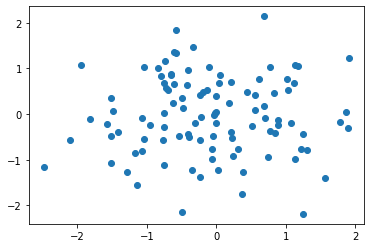

In [4]:
plt.scatter(z[:,0], z[:,1])

Now I apply a set of transformations W to get X. I want X to be a (103, 7) matrix, which means W has to be (7, 3). I will also add some mean $\mu$ and $\psi$ to add noise

In [5]:
W = np.array([[2, 3, 9], [9, 6, 10], [10, 9, 8], [7, 3, 2], [4, 2, 7], [7, 1, 1], [2, 7, 3]])
u = np.array([8, 2, 6, 10, 3, 5, 2])

# based on Mikio SNR, use high lambdas
# I will use low lambdas
psi = np.diag([1, 3, 2, 1, 2, 3, 1]) # Low lambdas (noise) causes weights plot to have a slope of 1
# psi = np.diag([10, 30, 20, 10, 20, 30, 10]) # High lambdas (noise) causes weights plot to not have a slope of 1

noise_ = np.random.multivariate_normal(u, psi, size=(N,))


X = (W @ z.T).T + noise_

X[:5]

array([[  5.81752597,   0.39186487,   9.51891238,  15.59896395,
         -2.87059303,   1.97866475,  -0.36673006],
       [  1.26387622, -17.80349292,  -5.26431301,  -2.62117956,
         -7.80623   ,  -9.05514937,  -8.02845987],
       [ -2.53802256, -23.79315107, -23.30100968,  -7.57789105,
         -7.56227677,  -9.0240229 ,   0.26871773],
       [ 16.31931585,   4.65272969,  15.07538403,  14.88862403,
          4.78927213,  16.71835745,   3.78764485],
       [ -0.19311437,  -6.6494854 ,  -5.09039378,   3.74738751,
         -4.02027397,  -4.16637998,   0.74497342]])

I will use the "_L" suffix to denote learned variables. We are going to start with randomly initialized variables.

In [181]:
mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.normal(0, 1, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))
G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)

Expectation Step

In [182]:
Ez_L = np.empty(X.shape[0], dtype=object)
Ezzt_L = np.empty(X.shape[0], dtype=object)

In [183]:
for i in range(0, X.shape[0]):
    Ez_L[i] = G @ W_L.T @ inv(psi_L) @ (X[i].reshape(-1, 1) - mu_x)
    Ezzt_L[i] = G + Ez_L[i] @ Ez_L[i].T

Maximization Step

In [184]:
# Compute new W

w_sum1 = np.zeros(shape=(X.shape[1], M))

for i in range(X.shape[0]):
    w_sum1 += (X[i].reshape(-1, 1) - mu_x) @ Ez_L[i].T

W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))


In [185]:
# Compute new psi. Assuming S is the sample covariance.

psi_sum1 = np.zeros(shape=(M, X.shape[1]))

for i in range(X.shape[0]):
    psi_sum1 += Ez_L[i] @ (X[i].reshape(-1, 1) - mu_x).T
    
psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))

### Calculate Likelihood
Here I will define a method to calculate likelihood so that we can measure it over the epochs

In [6]:
def likelihood():
    C = W_L @ W_L.T + psi_L
    return -(N/2) * (np.log(det(C)) + np.trace(np.cov(X.T) * inv(C)))

Now we can put it all together to try and see how close our estimation was to the real W

In [7]:
epochs = 250  # Number of iterations to run EM
M = 3  # Number of latent variables

mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.uniform(low=-5, high=5, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))
likelihoods = np.zeros(shape=epochs)

for i in range(epochs):
    # Expectation Step
    Ez_L = np.empty(X.shape[0], dtype=object)
    Ezzt_L = np.empty(X.shape[0], dtype=object)
    G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)
    
    for j in range(0, X.shape[0]):
        Ez_L[j] = G @ W_L.T @ inv(psi_L) @ (X[j].reshape(-1, 1) - mu_x)
        Ezzt_L[j] = G + Ez_L[j] @ Ez_L[j].T
        
        
    # Compute new W

    w_sum1 = np.zeros(shape=(X.shape[1], M))

    for j in range(X.shape[0]):
        w_sum1 += (X[j].reshape(-1, 1) - mu_x) @ Ez_L[j].T

    W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))
    
    
    # Compute new psi. Assuming S is the sample covariance.

    psi_sum1 = np.zeros(shape=(M, X.shape[1]))

    for j in range(X.shape[0]):
        psi_sum1 += Ez_L[j] @ (X[j].reshape(-1, 1) - mu_x).T
        
    psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))
    
    likelihoods[i] = likelihood()

In [29]:
W_L, W

(array([[ -2.43468024,  -2.60702958,   7.81063658],
        [ -5.17992821,  -8.68802301,   7.39732618],
        [ -2.91138262, -11.70895933,   6.43422687],
        [ -3.16877488,  -6.43171929,   0.70822045],
        [ -3.78211556,  -3.28789559,   5.46484925],
        [ -4.43874453,  -5.10849294,  -0.96080079],
        [  2.77661172,  -5.62155117,   3.73085573]]),
 array([[ 2,  3,  9],
        [ 9,  6, 10],
        [10,  9,  8],
        [ 7,  3,  2],
        [ 4,  2,  7],
        [ 7,  1,  1],
        [ 2,  7,  3]]))

### Check if W and $\psi$ are correct
First get $WW^T$ and $W'W'^T$ and flatten them. Then plot them. Their slope should equal 1 if our EM model is correct

Slope:  0.7370411322693609
Intercept:  5.707000938672849


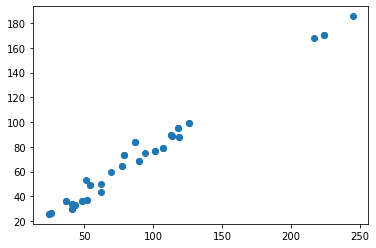

In [8]:
mdl = LinearRegression().fit(np.ndarray.flatten(W @ W.T).reshape(-1, 1), np.ndarray.flatten(W_L @ W_L.T))
print("Slope: ", mdl.coef_[0])
print("Intercept: ", mdl.intercept_)

plt.scatter(x=np.ndarray.flatten(W @ W.T), y=np.ndarray.flatten(W_L @ W_L.T))

Since our slope is 1, we are confident that the Weights portion of our EM is correct

Slope:  0.9939604916505237
Intercept:  -0.2668856468071965


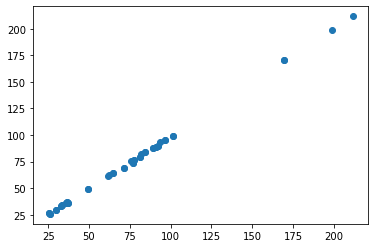

In [9]:
mdl = LinearRegression().fit(np.ndarray.flatten(np.cov(X.T)).reshape(-1, 1), np.ndarray.flatten(W_L @ W_L.T + psi_L))
print("Slope: ", mdl.coef_[0])
print("Intercept: ", mdl.intercept_)

plt.scatter(x=np.ndarray.flatten(np.cov(X.T)), y=np.ndarray.flatten(W_L @ W_L.T + psi_L))

The model we fit is $\Sigma = W'W'^T + \psi$ \
The evaluation criteria we are using here is $W'W'^T + \psi = S$. \
We can measure the slope or residual between these 2 variables to see how well our model is performing.
This evaluation criteria is from page 6 of Statistics of Factor Analysis

### Evaluate Likelihood over epochs
Graph of negative log likelihood (neglecting terms constant with respect to $\psi$)

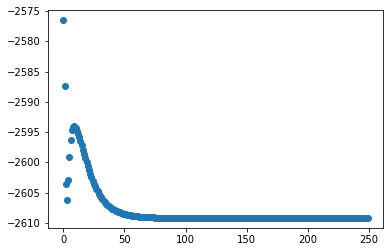

In [10]:
plt.scatter(x= range(epochs), y= likelihoods)

In [112]:
likelihoods[-5:]

array([-7962.64032582, -7962.65169735, -7962.66294169, -7962.67406029,
       -7962.68505458])

### How did I make sure the coding was done correctly?
For any problems I was having, I would look up the numpy documentation to see if the behavior I was getting was right.

### How I made sure the math I was doing was correct?

The biggest thing was to always make sure that my matrix dimensions were correct. After this, I just trusted the formulas in the book. I would also keep printing the output of steps along the way to make sure everything was correct.

### How did I plan my coding to be right?
My plan was to reverse engineer a set of latent weights. This way I had a concrete dataset that I could compare my output to, so that I could see if the model was working correctly. Other steps included using for loops instead of matrix operations. I understand matrix operations, however I do not understand the math enough to apply them to this scenario, so I stuck with loops to minimize any errors. I sacrifice run time, but it should have less problems.